In [1]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler,OrdinalEncoder,FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import precision_score,classification_report,recall_score,f1_score,accuracy_score,average_precision_score
from sklearn.metrics import PrecisionRecallDisplay,RocCurveDisplay
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.cluster import KMeans
from pprint import pprint

In [2]:
# Reading and splitting data to independent features and target variable
df = pd.read_csv(r'data\raw\Bio-Signal-Analysis.zip',compression='zip')
df.drop(['ID','oral','Cholesterol'],axis=1,inplace=True)

X = df.iloc[:,:-1]
y = df.iloc[:,-1]

- Checking if the classes are balanced

In [3]:
(y.value_counts()/len(y)) * 100

smoking
0    63.271206
1    36.728794
Name: count, dtype: float64

- The number of non smokers are almost double the amount of smokers in our dataset. Since the classes are imbalanced we will not use accuracy score as the eval metric
- For this dataset we will optimize the model for recall, because in this particular scenario we want to `reduce False Negatives` ie. we dont want to misclassify a smoker as a non smoker.

- To start with, we will try `Feature Engineering` to see if we can improve predictive performance. So before that lets check the baseline performace of the models without Feature Engineering.

In [3]:
# Stratified splitting since classes are imbalanced
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.2,random_state=300)

# Preprocessor object
col_transformer = make_column_transformer(
    (OrdinalEncoder(),['gender','tartar']),
    (StandardScaler(),[col for col in X.columns if col not in ['gender','tartar','dental caries','Urine protein',
                                                               'hearing(left)','hearing(right)']]),
    remainder='passthrough'
)

# Algorithm Pipelines to see how they perform with this dataset
model_pipe_logistic = make_pipeline(col_transformer,LogisticRegression())
model_pipe_xg = make_pipeline(col_transformer,XGBClassifier(objective='binary:logistic'))
model_pipe_gb =make_pipeline(col_transformer,GradientBoostingClassifier())
model_pipe_cat = make_pipeline(col_transformer,CatBoostClassifier(verbose=0))

# For startified splitting during cross validation
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=300)

- We will check the base performance metrics using cross validation on the training set

In [4]:
pipe_list = [model_pipe_logistic, model_pipe_xg, model_pipe_gb, model_pipe_cat]
scores = []

for pipe in pipe_list:
    scores.append(cross_val_score(pipe, X_train, y_train, cv=cv, scoring='recall'))

In [5]:
for idx, pipe in enumerate(pipe_list):
    mean_score = np.mean(scores[idx])
    std_score = np.std(scores[idx])
    model_name = pipe.steps[-1][1].__class__.__name__
    print(f"For ({model_name}):")
    print(f"- Mean Recall: {mean_score:.4f}")
    print(f"- Standard deviation: {std_score:.4f}")
    print('--'*20,'\n')

For (LogisticRegression):
- Mean Recall: 0.6981
- Standard deviation: 0.0053
---------------------------------------- 

For (XGBClassifier):
- Mean Recall: 0.7182
- Standard deviation: 0.0095
---------------------------------------- 

For (GradientBoostingClassifier):
- Mean Recall: 0.7174
- Standard deviation: 0.0078
---------------------------------------- 

For (CatBoostClassifier):
- Mean Recall: 0.7221
- Standard deviation: 0.0085
---------------------------------------- 



#### **Feature Engineering**

- Checking the correlation between current features

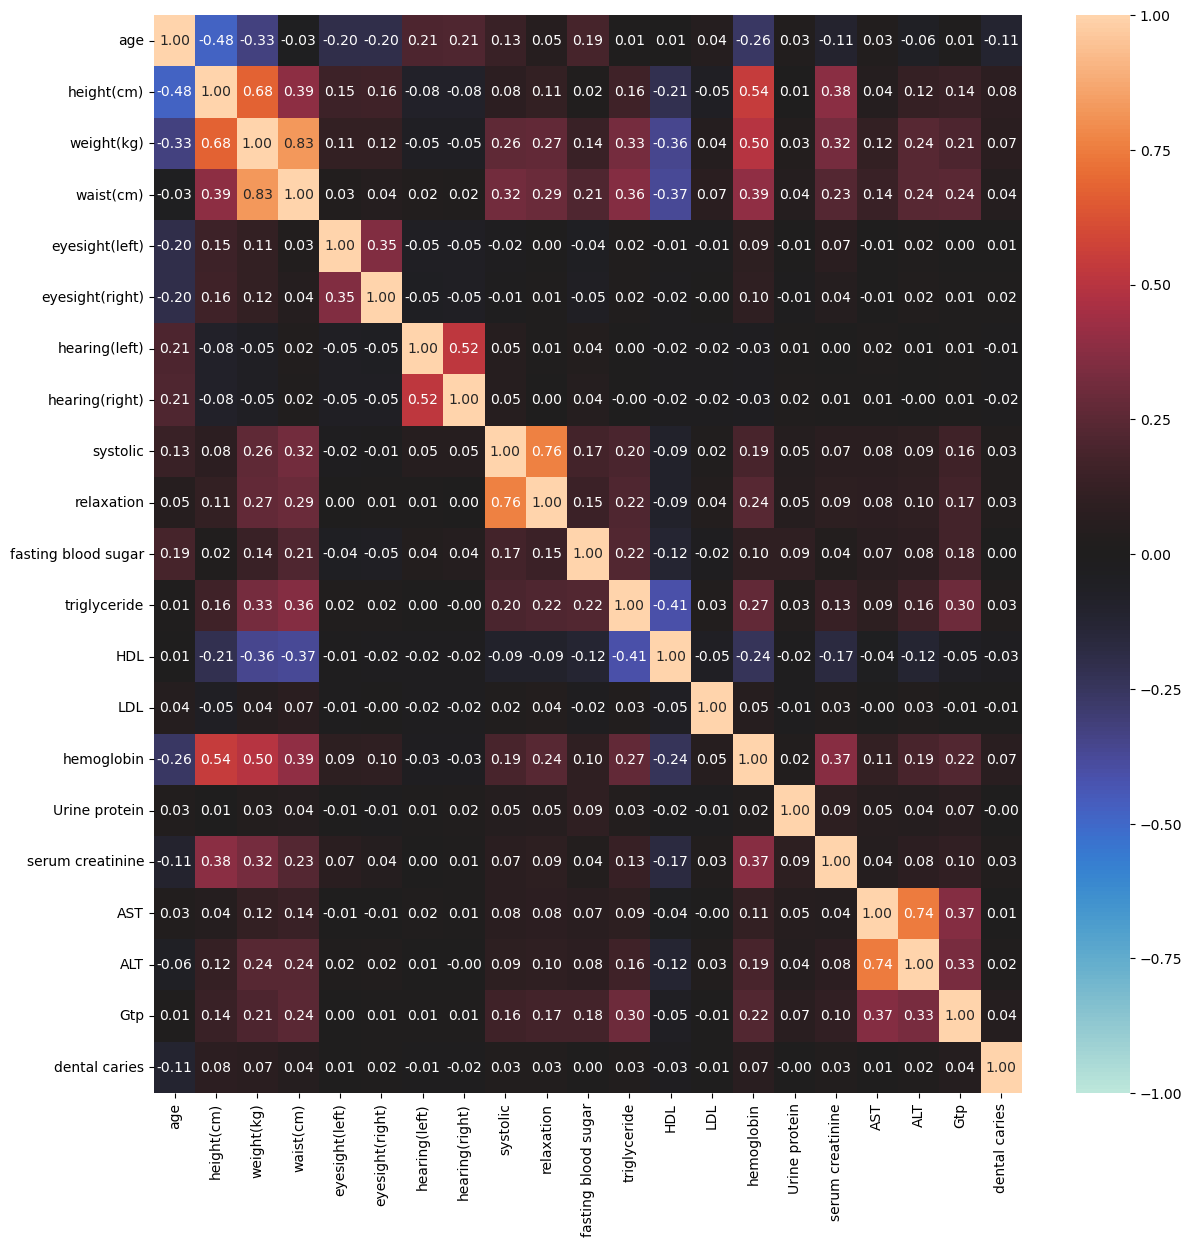

In [6]:
plt.figure(figsize=(14,14))
sb.heatmap(X_train.corr(numeric_only=True), cmap='icefire', vmin=-1, vmax=1, annot=True, fmt='0.2f');

- For forming new features, first we will apply PCA on this dataset and get the loadings of the features for each principal components
- The loadings of a principal componet indicate the weights of each feature for the given principal component
- It can tell us how the features are interacting and also give ideas for feature engineering

In [7]:
# PCA should be applied on continuous numerical data. So we will exclude the categotical features from it.
PCA_cols = [col for col in X.columns if col not in ['gender','tartar','dental caries','Urine protein','hearing(left)','hearing(right)']]
# We will standardize the data first and then apply PCA
pca_pipe = make_pipeline(StandardScaler(),PCA())

X_pca = pd.DataFrame(pca_pipe.fit_transform(X[PCA_cols]),
                     columns=[f'PCA{i+1}' for i in range(len(X[PCA_cols].columns))])
X_pca.sample(3)

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14,PCA15,PCA16,PCA17
33831,1.691700,4.168008,0.549336,0.435545,1.778208,-3.036970,1.018695,0.653026,-0.613418,0.337615,-0.026702,1.158393,0.333108,-0.077699,0.106976,-0.001423,-0.242012
7182,-1.736950,-1.206648,0.795051,-1.089297,0.739235,-0.292349,-0.594684,0.120470,0.215823,-0.253778,-0.256121,0.052505,-0.138365,-0.256443,-0.207939,0.824788,-0.035121
53856,2.681728,0.906636,-0.661668,-0.813834,0.826526,0.236866,0.309831,0.321112,-0.976401,-1.385556,0.224651,0.481577,0.769049,-0.206912,0.047610,0.138797,-0.027584


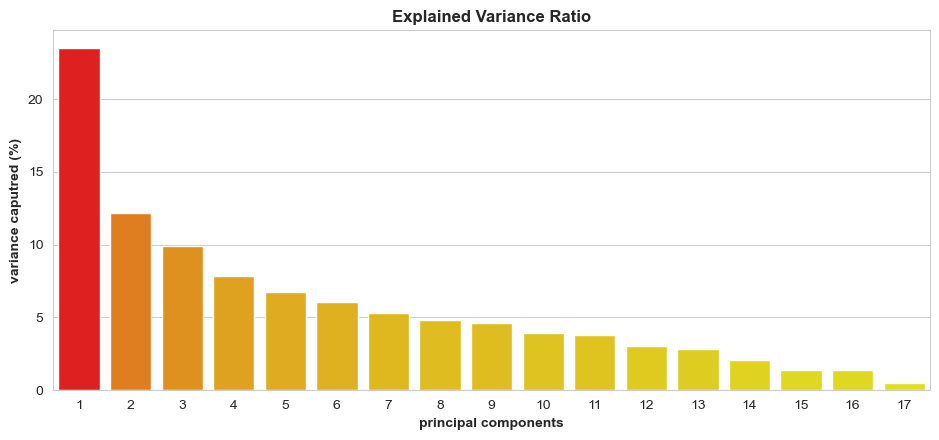

In [8]:
# Lets see the variance captured by each component
y_values = pca_pipe.steps[-1][1].explained_variance_ratio_*100
x_values = [f'{i+1}' for i in range(len(X[PCA_cols].columns))]
sb.set_style('whitegrid')

plt.figure(figsize=(9.5,4.5))
sb.barplot(x=x_values,y=y_values,hue=y_values,palette='autumn_r',legend=False)
plt.title('Explained Variance Ratio',fontweight='bold')
plt.ylabel('variance caputred (%)',fontweight='bold')
plt.xlabel('principal components',fontweight='bold')
plt.tight_layout();

In [9]:
# Making a dataframe with loadings of each components
loadings = pd.DataFrame(pca_pipe.steps[-1][1].components_.T,
                        columns=[f'PCA{i+1}' for i in range(len(X[PCA_cols].columns))],
                        index=X[PCA_cols].columns)
loadings

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14,PCA15,PCA16,PCA17
age,-0.127561,0.456175,-0.141472,-0.131151,0.196812,0.042164,0.220221,0.214206,0.327823,-0.350249,-0.006163,-0.408035,0.036469,0.410122,0.123224,-0.091996,0.116932
height(cm),0.328729,-0.359044,0.005319,-0.020583,-0.216812,-0.104959,0.032357,-0.115266,-0.017579,0.053214,-0.019783,-0.005214,-0.112188,0.762902,0.096706,-0.035329,-0.285395
weight(kg),0.423063,-0.155592,-0.078509,-0.085613,-0.078543,0.021495,-0.194446,-0.233870,0.206727,-0.224076,0.055384,0.078115,0.069356,0.015392,-0.032221,-0.026978,0.758453
waist(cm),0.383776,0.044091,-0.124186,-0.150792,0.035848,0.064882,-0.203185,-0.217359,0.317474,-0.411344,0.071891,-0.043906,0.131356,-0.300949,-0.080217,-0.029486,-0.571287
eyesight(left),0.069621,-0.269778,0.081442,0.391791,0.484296,0.025693,0.108593,0.075095,0.117433,0.029547,0.698709,-0.075629,-0.028811,0.012846,0.002130,0.001438,-0.005098
eyesight(right),0.072424,-0.263061,0.081007,0.397428,0.492014,0.030527,0.032798,0.009416,0.090034,-0.147779,-0.697332,-0.001515,0.024541,-0.001711,-0.005468,0.003761,0.000851
systolic,0.222327,0.315560,-0.343751,0.421430,-0.139061,0.024722,-0.067881,0.100156,0.020218,0.070908,-0.005452,0.067992,-0.058442,0.065735,-0.012138,0.708896,-0.011368
relaxation,0.234062,0.276696,-0.323983,0.448128,-0.148130,0.052207,-0.061735,0.104951,-0.082573,0.150762,-0.014603,0.085041,-0.054277,-0.034068,0.024944,-0.693837,-0.015644
fasting blood sugar,0.130508,0.254396,-0.109532,-0.144479,0.278017,-0.330039,0.409296,-0.525826,0.209421,0.433513,-0.050660,0.123329,-0.061708,-0.035295,-0.022154,-0.005613,-0.000108
triglyceride,0.264644,0.147987,-0.078979,-0.228417,0.367884,-0.091917,-0.106783,0.181479,-0.493893,0.053310,0.031334,0.136241,0.608330,0.152755,-0.037187,0.019282,-0.007509


In [10]:
# These are the weights of principal component 1. Similary we can check for every component 
# To get a better idea of how the features are interacting for each components
loadings['PCA1'].sort_values(axis=0,ascending=False)

weight(kg)             0.423063
waist(cm)              0.383776
hemoglobin             0.339465
height(cm)             0.328729
triglyceride           0.264644
relaxation             0.234062
ALT                    0.225707
serum creatinine       0.222563
systolic               0.222327
Gtp                    0.220575
AST                    0.166577
fasting blood sugar    0.130508
eyesight(right)        0.072424
eyesight(left)         0.069621
LDL                    0.027652
age                   -0.127561
HDL                   -0.234826
Name: PCA1, dtype: float64

- Well will add kmeans clusters as a new feature to the training dataset

In [11]:
scaler_cols = [col for col in X.columns if col not in ['gender','tartar','dental caries','Urine protein','hearing(left)','hearing(right)']]
scaler = StandardScaler()
X_train_stdzd = pd.DataFrame(scaler.fit_transform(X_train[scaler_cols]),
                             columns=scaler_cols)

# kmeans clustering with 20 clusters. Trained on X_train.
kmeans = KMeans(n_clusters=20,init='k-means++',n_init=50)
kmeans = kmeans.fit(X_train_stdzd)

- Creating a function for adding new features for both training and testing data set

In [12]:
def CreateFeatures(X):
    '''
    Function for Feature Engineering. Returns a DataFrame with the new features added.
    '''
    # Features based on interactions from PCA loadings and based on the domain
    X_temp = X.copy(deep=True)
    
    X_temp['weight/hdl'] = X_temp['weight(kg)'] / X_temp['HDL']
    X_temp['height/age'] = X_temp['height(cm)'] / X_temp['age']
    X_temp['bmi'] = X_temp['weight(kg)'] / ((X_temp['height(cm)']/100) ** 2)
    X_temp['systolic/relaxing'] = X_temp['systolic'] / X_temp['relaxation']
    X_temp['weight/waist'] = X_temp['weight(kg)'] / X_temp['waist(cm)']
    X_temp['hemoglobin/relaxation'] = X_temp['hemoglobin'] / X_temp['relaxation']
    X_temp['serum creatinine/fasting blood sugar'] = X_temp['serum creatinine'] / X_temp['fasting blood sugar']
    X_temp['LDL/fasting blood sugar'] = X_temp['LDL'] / X_temp['fasting blood sugar']
    X_temp['ALT/Gtp'] = X_temp['ALT'] / X_temp['Gtp']
    X_temp['serum creatinine/AST'] = X_temp['serum creatinine'] / X_temp['AST']
    X_temp['LDL/triglyceride'] = X_temp['LDL'] / X_temp['triglyceride']

    # Adding kmeans labels as a feature variable
    X_temp['labels'] = kmeans.predict(X_temp[scaler_cols])
    
    return X_temp

- Adding the steps to pipeline

In [13]:
# Removing the categorical type columns from standardization
stdzn_cols = [col for col in CreateFeatures(X_train).columns if col not in ['gender','tartar','labels','dental caries','Urine protein','hearing(left)',
                                                                            'hearing(right)']]

# Converting CreateFeatures function to a transformer object that can be used in pipelines
create_features = FunctionTransformer(CreateFeatures)

# Preprocessing Column transformer object for Ordinal encoding categorical types and standardizing numerical variables
col_transformer = make_column_transformer(
    (OrdinalEncoder(), ['gender','tartar']),
    (StandardScaler(), stdzn_cols),
    remainder='passthrough'
)

In [14]:
# Pipelines for training with XGBClassifier & CatBoostClassifier
pipe_xg = make_pipeline(
    create_features,
    col_transformer,
    XGBClassifier(objective='binary:logistic')
)

pipe_cb = make_pipeline(
    create_features,
    col_transformer,
    CatBoostClassifier(verbose=0)
)

- Checking whether the new features made any performance improvements
- Same as before we will use cross validation with the new features added

In [15]:
score_xg = cross_val_score(pipe_xg,X_train,y_train,cv=cv,scoring='recall')
mean_score = np.mean(score_xg)
std_score = np.std(score_xg)
model_name = pipe_xg.steps[-1][1].__class__.__name__
print(f"For ({model_name}):")
print(f"- Mean Recall: {mean_score:.4f}")
print(f"- Standard deviation: {std_score:.4f}")

For (XGBClassifier):
- Mean Recall: 0.7262
- Standard deviation: 0.0111


In [16]:
# Checking whether Recall has increased from before feature engineering for XGBClassifier
mean_score > np.mean(scores[2])

True

In [17]:
score_cb = cross_val_score(pipe_cb,X_train,y_train,cv=cv,scoring='recall')
mean_score = np.mean(score_cb)
std_score = np.std(score_cb)
model_name = pipe_cb.steps[-1][1].__class__.__name__
print(f"For ({model_name}):")
print(f"- Mean Recall: {mean_score:.4f}")
print(f"- Standard deviation: {std_score:.4f}")

For (CatBoostClassifier):
- Mean Recall: 0.7260
- Standard deviation: 0.0057


In [18]:
# Checking whether Recall has increased from before feature engineering for CatBoostClassifier
mean_score > np.mean(scores[-1])

True

- Recall has slightly improved from feature engineering, that enabled the algorithms to better learn the data.

- We'll now check the metrics for testing set

In [19]:
pipe_xg.fit(X_train,y_train)
y_pred_xg = pipe_xg.predict(X_test)
y_train_pred_xg = pipe_xg.predict(X_train)

print('Training Metrics (XGBClassifier):\n','-'*69,f'\n{classification_report(y_train,y_train_pred_xg)}')
print('\nTest Metrics (XGBClassifier):\n','-'*69,f'\n{classification_report(y_test,y_pred_xg)}')

Training Metrics (XGBClassifier):
 --------------------------------------------------------------------- 
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     28189
           1       0.84      0.86      0.85     16364

    accuracy                           0.89     44553
   macro avg       0.88      0.88      0.88     44553
weighted avg       0.89      0.89      0.89     44553


Test Metrics (XGBClassifier):
 --------------------------------------------------------------------- 
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      7048
           1       0.71      0.73      0.72      4091

    accuracy                           0.79     11139
   macro avg       0.78      0.78      0.78     11139
weighted avg       0.79      0.79      0.79     11139



In [20]:
pipe_cb.fit(X_train,y_train)
y_pred_cb = pipe_cb.predict(X_test)
y_train_pred_cb = pipe_cb.predict(X_train)

print('Training Metrics (CatBoostClassifier):\n','-'*69,f'\n{classification_report(y_train,y_train_pred_cb)}')
print('\nTest Metrics (CatBoostClassifier):\n','-'*69,f'\n{classification_report(y_test,y_pred_cb)}')

Training Metrics (CatBoostClassifier):
 --------------------------------------------------------------------- 
              precision    recall  f1-score   support

           0       0.89      0.88      0.88     28189
           1       0.80      0.82      0.81     16364

    accuracy                           0.86     44553
   macro avg       0.84      0.85      0.85     44553
weighted avg       0.86      0.86      0.86     44553


Test Metrics (CatBoostClassifier):
 --------------------------------------------------------------------- 
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      7048
           1       0.70      0.73      0.71      4091

    accuracy                           0.78     11139
   macro avg       0.77      0.77      0.77     11139
weighted avg       0.79      0.78      0.79     11139



- The Recall of smokers (class 1) are much lower than non smokers for both these models.

- One of the reasons for this because the the number of smokers are only about half of the number of non smokers. Since the models have lesser number of smoker's samples to learn from, it will make more error for predicting these than the other class. We will see if we can improve these numbers using resampling methods.

In [21]:
# Saving the preprocessed & transformed X_train and X_test for further use in Resampling and Hyperparameter Tuning
preprocessor = make_pipeline(
    create_features,
    col_transformer
)

X_train_v2 = pd.DataFrame(preprocessor.fit_transform(X_train),
                          columns=[x.split('__')[-1] for x in preprocessor[-1].get_feature_names_out()],
                          index=X_train.index)

X_test_v2 = pd.DataFrame(preprocessor.transform(X_test),
                         columns=[x.split('__')[-1] for x in preprocessor[-1].get_feature_names_out()],
                         index=X_test.index)

#### **Resampling & Hyperparameter Tuning**

- We will use the `Optuna` for tuning the Hyperparameters to find the best performing model.

- Optuna is a hyperparameter tuning and optimization library. It automates the process of finding the best hyperparameters for a machine learning algorithm.

- Rather than giving a set number of values for hyperparameters, optuna allows us to define a search space for these hyperparameters.

- Optuna then employs several search algorithms (eg bayesian optimization) to explore the defined search space efficiently and figure out the best hyperpaameters for the model according to the objective function. 

In [25]:
# Libraries for Hyperparameter Optimization & Resampling
import optuna
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.combine import SMOTETomek

# StratifiedKFold object for cross-validation during hyperparameter tuning 
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=300)

In [9]:
# For printing test metrics
def GetMetrics(X_train, y_train, X_test, y_test, params, experiment,results_for_recall):
    model = XGBClassifier(**params).fit(X_train,y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]

    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    report = classification_report(y_test,y_pred)
    average_precision = average_precision_score(y_test,y_pred_proba)
    
    metrics_list = [recall, precision, f1, accuracy, average_precision]
    results_for_recall.loc[len(results_for_recall)] = [experiment] + metrics_list
        
    print(f'Test Set Metrics ({experiment}):')
    print('=='*35)
    print(f' - Average Precision: {average_precision:4f}')
    print(f' - Precision: {precision:.4f}')
    print(f' - Recall: {recall:.4f}\n')
    print(' - Classification Report:','\n','-'*69)
    print(report)

- We will first get the best baseline performance of the model before Resampling. We will be optimizing for Recall as discussed before.

In [10]:
def objective(trial):

    # Defining the hyperparameter search space 
    xgb = XGBClassifier(
        n_estimators = trial.suggest_int('n_estimators', 50, 2000),
        max_depth = trial.suggest_int('max_depth', 2, 12),
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10),
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.2, 1),
        subsample = trial.suggest_float('subsample', 0.2, 1),
        learning_rate = trial.suggest_float('learning_rate', 0.001, 1, log=True),
        reg_alpha = trial.suggest_float('reg_alpha',0.01, 100, log=True),
        reg_lambda = trial.suggest_float('reg_lambda',0.01, 100, log=True),
        objective='binary:logistic',
        n_jobs=-1
    )
    
    avg_recall = []

    # Using cross validation to obatin the individual Recall's of each folds
    for fold_number, (train_index, val_index) in enumerate(folds.split(X_train_v2,y_train)):
        X_train_split, y_train_split = X_train_v2.iloc[train_index], y_train.iloc[train_index]
        X_val_split, y_val_split = X_train_v2.iloc[val_index], y_train.iloc[val_index]

        # Getting the recall of current fold. It will be provided to the pruner
        xgb.fit(X_train_split, y_train_split)
        y_val_pred = xgb.predict(X_val_split)
        fold_recall = recall_score(y_val_split,y_val_pred)
        avg_recall.append(fold_recall)

        # For pruning a step early if eval metrics looks unpromising
        trial.report(fold_recall, step=fold_number)
        if trial.should_prune():
            raise optuna.TrialPruned()

    # The mean Recall after cross validation is returned to optuna as the metric to be optimized for
    return np.mean(avg_recall)

# Here the startegy is to maximize (Recall) as provided in the direction parameter
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.HyperbandPruner(), study_name='XGBClassifier Tuning (no resampling)')
# Will run for 100 trials or 3 hours, whichever happens first
study.optimize(objective, n_trials=100, timeout=3*60*60)
# Saving the current optimization study. It can be used to resume optimization process from where it was stopped rather than restarting.
joblib.dump(study,'Optuna_study_Baseline.pkl')

# Getting the best hyperparameters
best_params_initial = study.best_trial.params
print('Best hyperparameters are:')
best_params_initial

[I 2024-04-20 17:29:25,543] A new study created in memory with name: XGBClassifier tuning (no resampling)


[I 2024-04-20 17:30:34,623] Trial 0 finished with value: 0.7075895281614335 and parameters: {'n_estimators': 1571, 'max_depth': 2, 'min_child_weight': 9, 'colsample_bytree': 0.8065096251049708, 'subsample': 0.20862882307077968, 'learning_rate': 0.07203713377375623, 'reg_alpha': 14.856057830817825, 'reg_lambda': 41.700719579215985}. Best is trial 0 with value: 0.7075895281614335.
[I 2024-04-20 17:31:27,130] Trial 1 finished with value: 0.7080788618742516 and parameters: {'n_estimators': 970, 'max_depth': 11, 'min_child_weight': 3, 'colsample_bytree': 0.6603360404659273, 'subsample': 0.7603787528644625, 'learning_rate': 0.3435566874892739, 'reg_alpha': 61.80775081954692, 'reg_lambda': 20.05916772967148}. Best is trial 1 with value: 0.7080788618742516.
[I 2024-04-20 17:31:59,276] Trial 2 pruned. 
[I 2024-04-20 17:32:38,136] Trial 3 finished with value: 0.7097279026666279 and parameters: {'n_estimators': 741, 'max_depth': 3, 'min_child_weight': 3, 'colsample_bytree': 0.6493997020509314, 's

Best hyperparameters are:


{'n_estimators': 965,
 'max_depth': 12,
 'min_child_weight': 2,
 'colsample_bytree': 0.6222009728281621,
 'subsample': 0.7232065241476207,
 'learning_rate': 0.012829656264280388,
 'reg_alpha': 0.021304111555481273,
 'reg_lambda': 0.49710452512397657}

In [11]:
results_for_recall = pd.DataFrame(columns=['XGBClassifier (data input)','Recall','Precision','F1 Score','Accuracy','Average Precision'])

GetMetrics(X_train_v2,y_train,X_test_v2,y_test,best_params_initial,'Baseline (No Resampling)',results_for_recall)

Test Set Metrics (Baseline (No Resampling)):
 - Average Precision: 0.837669
 - Precision: 0.7667
 - Recall: 0.7849

 - Classification Report: 
 ---------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      7048
           1       0.77      0.78      0.78      4091

    accuracy                           0.83     11139
   macro avg       0.82      0.82      0.82     11139
weighted avg       0.83      0.83      0.83     11139



##### **- Random Oversampling**

- As the name suggests it randomly adds more samples from class 1 (in our dataset) to balance the classes

In [9]:
ros = RandomOverSampler(random_state=300)
X_train_ros, y_train_ros = ros.fit_resample(X_train_v2,y_train)

# The classes are now in balance
y_train_ros.value_counts()

smoking
0    28189
1    28189
Name: count, dtype: int64

In [35]:
# For dataset with Random Oversampling
def objective(trial):

    # Defining the hyperparameter search space 
    xgb = XGBClassifier(
        n_estimators = trial.suggest_int('n_estimators', 50, 2000),
        max_depth = trial.suggest_int('max_depth', 2, 12),
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10),
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.2, 1),
        subsample = trial.suggest_float('subsample', 0.2, 1),
        learning_rate = trial.suggest_float('learning_rate', 0.001, 1, log=True),
        reg_alpha = trial.suggest_float('reg_alpha',0.01, 100, log=True),
        reg_lambda = trial.suggest_float('reg_lambda',0.01, 100, log=True),
        objective='binary:logistic',
        n_jobs=-1
    )
    
    avg_recall = []

    # Using cross validation to obatin the individual Recall's of each folds
    for fold_number, (train_index, val_index) in enumerate(folds.split(X_train_ros, y_train_ros)):
        X_train_split, y_train_split = X_train_ros.iloc[train_index], y_train_ros.iloc[train_index]
        X_val_split, y_val_split = X_train_ros.iloc[val_index], y_train_ros.iloc[val_index]

        # Getting the recall of current fold. It will be provided to the pruner
        xgb.fit(X_train_split, y_train_split)
        y_val_pred = xgb.predict(X_val_split)
        fold_recall = recall_score(y_val_split,y_val_pred)
        avg_recall.append(fold_recall)

        # For pruning a step early if eval metrics looks unpromising
        trial.report(fold_recall, step=fold_number)
        if trial.should_prune():
            raise optuna.TrialPruned()

    # The mean Recall after cross validation is returned to optuna as the metric to be optimized for
    return np.mean(avg_recall)

# Here the startegy is to maximize (Recall) as provided in the direction parameter
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.HyperbandPruner(), study_name='XGBClassifier Tuning (Random Oversampled Dataset)')
# Will run for 100 trials or 3 hours, whichever happens first
study.optimize(objective, n_trials=100, timeout=3*60*60)
# Saving the current optimization study. It can be used to resume optimization process from where it was stopped rather than restarting.
joblib.dump(study,'Optuna_study_ROS.pkl')

# Getting the best hyperparameters
best_params_ros = study.best_trial.params
print('Best hyperparameters:')
best_params_ros

[I 2024-04-20 22:41:30,005] A new study created in memory with name: XGBClassifier Tuning (Random Oversampled Dataset)


[I 2024-04-20 22:41:46,614] Trial 0 finished with value: 0.9092908853686336 and parameters: {'n_estimators': 211, 'max_depth': 2, 'min_child_weight': 1, 'colsample_bytree': 0.22403325133066299, 'subsample': 0.8504889177937158, 'learning_rate': 0.001544225747720043, 'reg_alpha': 60.630601820988865, 'reg_lambda': 0.15340145332274122}. Best is trial 0 with value: 0.9092908853686336.
[I 2024-04-20 22:43:37,089] Trial 1 finished with value: 0.9229132845790398 and parameters: {'n_estimators': 845, 'max_depth': 6, 'min_child_weight': 1, 'colsample_bytree': 0.6438182899592381, 'subsample': 0.32479133041606056, 'learning_rate': 0.003988409786032637, 'reg_alpha': 83.81210583032596, 'reg_lambda': 35.50649007862556}. Best is trial 1 with value: 0.9229132845790398.
[I 2024-04-20 22:44:19,144] Trial 2 pruned. 
[I 2024-04-20 22:44:56,465] Trial 3 finished with value: 0.879208333325467 and parameters: {'n_estimators': 234, 'max_depth': 3, 'min_child_weight': 4, 'colsample_bytree': 0.7186167714347065, 

Best hyperparameters:


{'n_estimators': 709,
 'max_depth': 11,
 'min_child_weight': 4,
 'colsample_bytree': 0.8467019767302157,
 'subsample': 0.8470671525397296,
 'learning_rate': 0.04390739035716512,
 'reg_alpha': 2.604405985474845,
 'reg_lambda': 3.634038605731421}

In [14]:
GetMetrics(X_train_ros,y_train_ros,X_test_v2,y_test,best_params_ros,'Random Oversampling',results_for_recall)

Test Set Metrics (Random Oversampling):
 - Average Precision: 0.831778
 - Precision: 0.7421
 - Recall: 0.8235

 - Classification Report: 
 ---------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      7048
           1       0.74      0.82      0.78      4091

    accuracy                           0.83     11139
   macro avg       0.82      0.83      0.82     11139
weighted avg       0.84      0.83      0.83     11139



##### **- SMOTE (Synthetic Minority Oversampling Technique)**

- SMOTE synthesizes elements for the minority class. It finds samples of the minority class in feature space, draws a line between these samples and synthesizes new samples at points along those lines.

In [15]:
smote = SMOTE(random_state=300)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train_v2,y_train)

# The classes are now in balance
y_train_SMOTE.value_counts()

smoking
0    28189
1    28189
Name: count, dtype: int64

In [16]:
# For dataset with SMOTE Resampling
def objective(trial):

    # Defining the hyperparameter search space 
    xgb = XGBClassifier(
        n_estimators = trial.suggest_int('n_estimators', 50, 2000),
        max_depth = trial.suggest_int('max_depth', 2, 12),
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10),
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.2, 1),
        subsample = trial.suggest_float('subsample', 0.2, 1),
        learning_rate = trial.suggest_float('learning_rate', 0.001, 1, log=True),
        reg_alpha = trial.suggest_float('reg_alpha',0.01, 100, log=True),
        reg_lambda = trial.suggest_float('reg_lambda',0.01, 100, log=True),
        objective='binary:logistic',
        n_jobs=-1
    )
    
    avg_recall = []

    # Using cross validation to obatin the individual Recall's of each folds
    for fold_number, (train_index, val_index) in enumerate(folds.split(X_train_SMOTE, y_train_SMOTE)):
        X_train_split, y_train_split = X_train_SMOTE.iloc[train_index], y_train_SMOTE.iloc[train_index]
        X_val_split, y_val_split = X_train_SMOTE.iloc[val_index], y_train_SMOTE.iloc[val_index]

        # Getting the recall of current fold. It will be provided to the pruner
        xgb.fit(X_train_split, y_train_split)
        y_val_pred = xgb.predict(X_val_split)
        fold_recall = recall_score(y_val_split,y_val_pred)
        avg_recall.append(fold_recall)

        # For pruning a step early if eval metrics looks unpromising
        trial.report(fold_recall, step=fold_number)
        if trial.should_prune():
            raise optuna.TrialPruned()

    # The mean Recall after cross validation is returned to optuna as the metric to be optimized for
    return np.mean(avg_recall)

# Here the startegy is to maximize (Recall) as provided in the direction parameter
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.HyperbandPruner(), study_name='XGBClassifier Tuning (SMOTE Resampled Dataset)')
# Will run for 100 trials or 3 hours, whichever happens first
study.optimize(objective, n_trials=100, timeout=3*60*60)
# Saving the current optimization study. It can be used to resume optimization process from where it was stopped rather than restarting.
joblib.dump(study,'Optuna_study_SMOTE.pkl')

# Getting the best hyperparameters
best_params_SMOTE = study.best_trial.params
print('Best hyperparameters:')
pprint(best_params_SMOTE,sort_dicts=False)

[I 2024-04-21 05:07:39,043] A new study created in memory with name: XGBClassifier Tuning (SMOTE Resampled Dataset)
[I 2024-04-21 05:08:18,483] Trial 0 finished with value: 0.8922275685348847 and parameters: {'n_estimators': 618, 'max_depth': 3, 'min_child_weight': 7, 'colsample_bytree': 0.2987569655657068, 'subsample': 0.4327814729311234, 'learning_rate': 0.010991357409613912, 'reg_alpha': 0.23216284433749876, 'reg_lambda': 34.52738612016346}. Best is trial 0 with value: 0.8922275685348847.
[I 2024-04-21 05:10:05,528] Trial 1 finished with value: 0.8451879819288045 and parameters: {'n_estimators': 1497, 'max_depth': 3, 'min_child_weight': 7, 'colsample_bytree': 0.6439056578495237, 'subsample': 0.7539312384535912, 'learning_rate': 0.2039876084073399, 'reg_alpha': 27.592167069013144, 'reg_lambda': 13.799499881555187}. Best is trial 0 with value: 0.8922275685348847.
[I 2024-04-21 05:10:28,444] Trial 2 finished with value: 0.8313526720624003 and parameters: {'n_estimators': 157, 'max_dept

Best hyperparameters:
{'n_estimators': 638,
 'max_depth': 2,
 'min_child_weight': 1,
 'colsample_bytree': 0.811022823717618,
 'subsample': 0.9762140625574364,
 'learning_rate': 0.0027772951848509097,
 'reg_alpha': 0.09692943936566759,
 'reg_lambda': 62.73669542833492}


In [17]:
GetMetrics(X_train_SMOTE,y_train_SMOTE,X_test_v2,y_test,best_params_SMOTE,'SMOTE Resampling',results_for_recall)

Test Set Metrics (SMOTE Resampling):
 - Average Precision: 0.679379
 - Precision: 0.5549
 - Recall: 0.9484

 - Classification Report: 
 ---------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.56      0.70      7048
           1       0.55      0.95      0.70      4091

    accuracy                           0.70     11139
   macro avg       0.75      0.75      0.70     11139
weighted avg       0.80      0.70      0.70     11139



##### **- Using SMOTETomek**

- It uses two methods SMOTE (for synthetic oversampling) and Tomek Links (undersampling). It is said to improve class separability.

- Tomek Links are instances of different classes in the feature space that are nearest neighbors of each other. In Tomek Links undersampling, these Tomek Links are identified and instances of the majority class is removed from these Tomek Links (improving class separability)

- In SMOTETomek the synthetic instances that form tomek links with instances from the majority classes are removed.

In [26]:
SMOTETomek = SMOTETomek(random_state=300)
X_train_SMOTETomek, y_train_SMOTETomek = SMOTETomek.fit_resample(X_train_v2,y_train)

# The classes are now in balance
y_train_SMOTETomek.value_counts()

smoking
0    27864
1    27864
Name: count, dtype: int64

In [16]:
# For dataset with SMOTETomek Resampling
def objective(trial):

    # Defining the hyperparameter search space 
    xgb = XGBClassifier(
        n_estimators = trial.suggest_int('n_estimators', 50, 2000),
        max_depth = trial.suggest_int('max_depth', 2, 12),
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10),
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.2, 1),
        subsample = trial.suggest_float('subsample', 0.2, 1),
        learning_rate = trial.suggest_float('learning_rate', 0.001, 1, log=True),
        reg_alpha = trial.suggest_float('reg_alpha',0.01, 100, log=True),
        reg_lambda = trial.suggest_float('reg_lambda',0.01, 100, log=True),
        objective='binary:logistic',
        n_jobs=-1
    )
    
    avg_recall = []

    # Using cross validation to obatin the individual Recall's of each folds
    for fold_number, (train_index, val_index) in enumerate(folds.split(X_train_SMOTETomek, y_train_SMOTETomek)):
        X_train_split, y_train_split = X_train_SMOTETomek.iloc[train_index], y_train_SMOTETomek.iloc[train_index]
        X_val_split, y_val_split = X_train_SMOTETomek.iloc[val_index], y_train_SMOTETomek.iloc[val_index]

        # Getting the recall of current fold. It will be provided to the pruner
        xgb.fit(X_train_split, y_train_split)
        y_val_pred = xgb.predict(X_val_split)
        fold_recall = recall_score(y_val_split,y_val_pred)
        avg_recall.append(fold_recall)

        # For pruning a step early if eval metrics looks unpromising
        trial.report(fold_recall, step=fold_number)
        if trial.should_prune():
            raise optuna.TrialPruned()

    # The mean Recall after cross validation is returned to optuna as the metric to be optimized for
    return np.mean(avg_recall)

# Here the startegy is to maximize (Recall) as provided in the direction parameter
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.HyperbandPruner(), study_name='XGBClassifier Tuning (SMOTETomek Resampled Dataset)')
# Will run for 100 trials or 3 hours, whichever happens first
study.optimize(objective, n_trials=100, timeout=3*60*60)
# Saving the current optimization study. It can be used to resume optimization process from where it was stopped rather than restarting.
joblib.dump(study,'Optuna_study_SMOTETomek.pkl')

# Getting the best hyperparameters
best_params_SMOTETomek = study.best_trial.params
print('Best hyperparameters:')
pprint(best_params_SMOTETomek,sort_dicts=False)

[I 2024-04-21 09:37:20,712] A new study created in memory with name: XGBClassifier Tuning (SMOTETomek Resampled Dataset)
[I 2024-04-21 09:39:11,804] Trial 0 finished with value: 0.9128767217372603 and parameters: {'n_estimators': 335, 'max_depth': 11, 'min_child_weight': 1, 'colsample_bytree': 0.2049002968887133, 'subsample': 0.36074714077161674, 'learning_rate': 0.0016021435349207898, 'reg_alpha': 0.8400802044599908, 'reg_lambda': 0.7780012728981774}. Best is trial 0 with value: 0.9128767217372603.
[I 2024-04-21 09:43:15,764] Trial 1 finished with value: 0.8613992791353748 and parameters: {'n_estimators': 1558, 'max_depth': 12, 'min_child_weight': 6, 'colsample_bytree': 0.2183490361949148, 'subsample': 0.5885642128770798, 'learning_rate': 0.04233649691031968, 'reg_alpha': 29.605009540759465, 'reg_lambda': 26.860605211271654}. Best is trial 0 with value: 0.9128767217372603.
[I 2024-04-21 09:45:12,517] Trial 2 finished with value: 0.9348461349236631 and parameters: {'n_estimators': 1589

Best hyperparameters:
{'n_estimators': 286,
 'max_depth': 2,
 'min_child_weight': 2,
 'colsample_bytree': 0.8332775220124636,
 'subsample': 0.7627408103394323,
 'learning_rate': 0.0012725014432214143,
 'reg_alpha': 16.54472242376152,
 'reg_lambda': 49.78867274037968}


In [21]:
GetMetrics(X_train_SMOTETomek,y_train_SMOTETomek,X_test_v2,y_test,best_params_SMOTETomek,'SMOTETomek Resampling',results_for_recall)

Test Set Metrics (SMOTETomek Resampling):
 - Average Precision: 0.664786
 - Precision: 0.5519
 - Recall: 0.9526

 - Classification Report: 
 ---------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.55      0.70      7048
           1       0.55      0.95      0.70      4091

    accuracy                           0.70     11139
   macro avg       0.75      0.75      0.70     11139
weighted avg       0.81      0.70      0.70     11139



`Results`

In [22]:
# Final performance metrics for test set for 
results_for_recall.sort_values('Recall',ascending=False)

,XGBClassifier (data input),Recall,Precision,F1 Score,Accuracy,Average Precision
3,SMOTETomek Resampling,0.952579,0.551905,0.698888,0.698537,0.664786
2,SMOTE Resampling,0.948423,0.554920,0.700171,0.701679,0.679379
1,Random Oversampling,0.823515,0.742070,0.780674,0.830057,0.831778
0,Baseline (No Resampling),0.784894,0.766714,0.775698,0.833288,0.837669


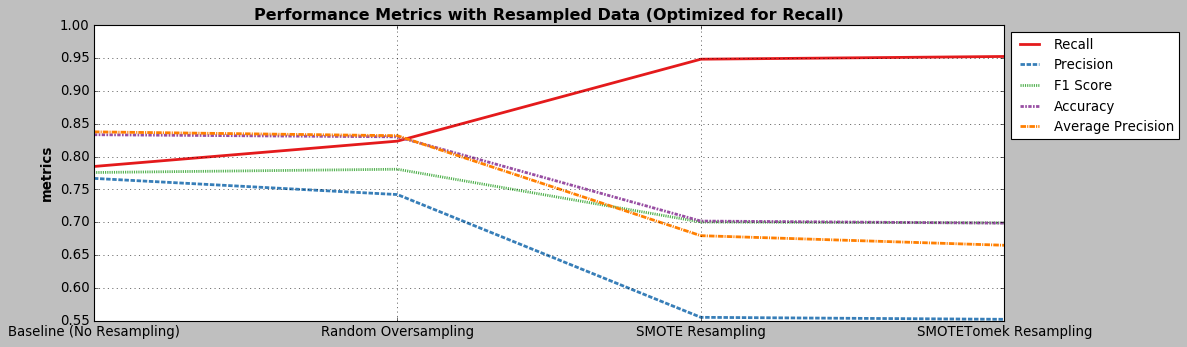

In [89]:
plt.style.use('classic')
plt.figure(figsize=(15,4.5))

sb.lineplot(results_for_recall.set_index('XGBClassifier (data input)'),linewidth=2.5,palette='Set1')
plt.title('Performance Metrics with Resampled Data (Optimized for Recall)',fontweight='bold')
plt.legend(loc='upper left',fontsize='medium',bbox_to_anchor=(1,1))
plt.ylabel('metrics',fontweight='bold')
plt.xlabel('')
plt.grid(True)
plt.tight_layout();

- The model with the best recall used SMOTETomek resampled data during training and achieved a recall of 95.25% but it came with a huge drop in precision

- Lets see it Precision-Recall curve and ROC curve of this model

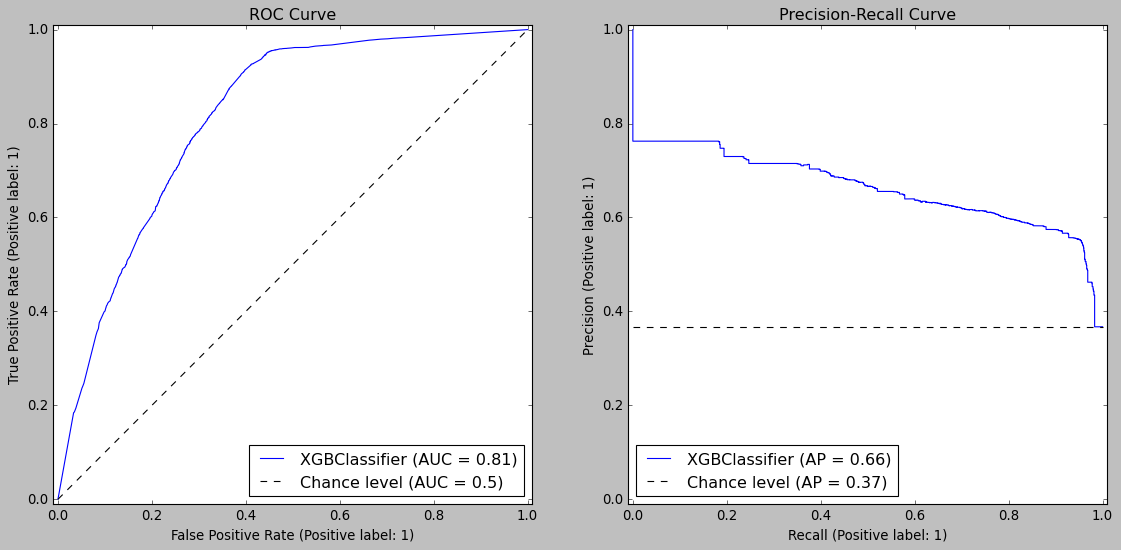

In [31]:
xgb_smotetomek = XGBClassifier(**best_params_SMOTETomek).fit(X_train_SMOTETomek,y_train_SMOTETomek)

fig, (ax1,ax2) = plt.subplots(1,2)
roc_curve = RocCurveDisplay.from_estimator(xgb_smotetomek, X_test_v2, y_test, response_method='predict_proba', plot_chance_level=True, ax=ax1)
pr_curve = PrecisionRecallDisplay.from_estimator(xgb_smotetomek, X_test_v2, y_test, response_method='predict_proba', plot_chance_level=True, ax=ax2)

roc_curve.figure_.set_size_inches(17,17)
roc_curve.ax_.set_title('ROC Curve')
pr_curve.ax_.set_title('Precision-Recall Curve')
plt.show()

- On the other hand, the tuned baseline model balanced had a good enough balance precision and recall, performing decently in both aspects

In [8]:
labels = results_for_recall.columns.to_list()[1:]
values = results_for_recall.iloc[:,1:].to_numpy()
groups = results_for_recall.iloc[:,0].to_numpy()

value_list = []
for i in range(len(values)):
    value_list.append(np.concatenate((values[i], [values[i][0]])))

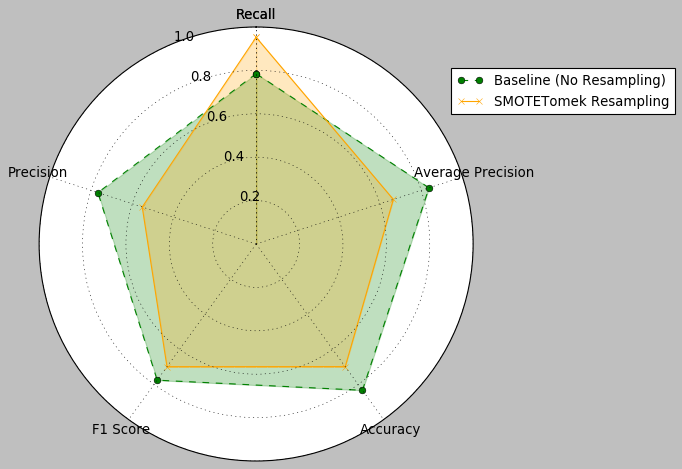

In [90]:
plt.style.use('classic')
angles = np.linspace(0, 2*np.pi, len(value_list[0]))
marker = np.concatenate((labels,[labels[0]]))

_ , ax = plt.subplots(figsize=(7,7), subplot_kw=dict(polar=True))
ax.plot(angles, value_list[0], 'o--', color='g', label=groups[0])
ax.plot(angles, value_list[3], 'x-', color='orange', label=groups[3])
# ax.plot(angles, value_list[1], '*-.', color='g', label=groups[1])
# ax.plot(angles, value_list[2], '+:', color='c', label=groups[2])

ax.fill_between(angles, value_list[0], alpha=0.25, color='g')
ax.fill_between(angles, value_list[3], alpha=0.25, color='orange')
# ax.fill_between(angles, value_list[1], alpha=0.2, color='g')
# ax.fill_between(angles, value_list[2], alpha=0.2, color='c')

ax.set_theta_zero_location('N')
ax.set_thetagrids(np.degrees(angles), labels=marker)
ax.set_rlim(0,1)
plt.legend(loc=(0.95, 0.8),fontsize='medium')
ax.grid(True)
plt.show()

- This radar plot clearly shows how the metrics stack up for both of models mentioned earlier.

- Since model trained on SMOTETomek resampled dataset has a recall of 95%, it makes sure that it classifies smoking people as smokers without missing any, 95% of the time (reducing False Negatives)

- If our priority is to avoid missing smokers, like for medical or support purposes, then choosing the model trained on SMOTETomek resampled data is the way to go.

<center>  ------------------------------------------------------------------------------------------------------------------------------ </center>

- We'll also experiment with tuning the two models mentioned above to optimize for Average Precision this time.

- Average precision is a good eval metric to use when both precision and recall are equally important. It summarizes the precision recall curve.

In [12]:
# For printing test metrics
def GetMetrics(X_train, y_train, X_test, y_test, params, experiment,results_avg_precision):
    model = XGBClassifier(**params).fit(X_train,y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]

    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    report = classification_report(y_test,y_pred)
    average_precision = average_precision_score(y_test,y_pred_proba)
    
    metrics_list = [recall, precision, f1, accuracy, average_precision]
    results_avg_precision.loc[len(results_avg_precision)] = [experiment] + metrics_list
        
    print(f'Test Set Metrics ({experiment}):')
    print('=='*35)
    print(f' - Average Precision: {average_precision:4f}')
    print(f' - Precision: {precision:.4f}')
    print(f' - Recall: {recall:.4f}\n')
    print(' - Classification Report:','\n','-'*69)
    print(report)

- Optimizing SMOTETomek Resampled dataset for Avg Precision

In [27]:
# For dataset with SMOTETomek Resampling optimizing for Average Precision
def objective(trial):

    # Defining the hyperparameter search space 
    xgb = XGBClassifier(
        n_estimators = trial.suggest_int('n_estimators', 50, 2000),
        max_depth = trial.suggest_int('max_depth', 2, 12),
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10),
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.2, 1),
        subsample = trial.suggest_float('subsample', 0.2, 1),
        learning_rate = trial.suggest_float('learning_rate', 0.001, 1, log=True),
        reg_alpha = trial.suggest_float('reg_alpha',0.01, 100, log=True),
        reg_lambda = trial.suggest_float('reg_lambda',0.01, 100, log=True),
        objective='binary:logistic',
        n_jobs=-1
    )
    
    avg_precision = []

    # Using cross validation to obatin the individual Recall's of each folds
    for fold_number, (train_index, val_index) in enumerate(folds.split(X_train_SMOTETomek, y_train_SMOTETomek)):
        X_train_split, y_train_split = X_train_SMOTETomek.iloc[train_index], y_train_SMOTETomek.iloc[train_index]
        X_val_split, y_val_split = X_train_SMOTETomek.iloc[val_index], y_train_SMOTETomek.iloc[val_index]

        # Getting the recall of current fold. It will be provided to the pruner
        xgb.fit(X_train_split, y_train_split)
        y_val_pred_proba = xgb.predict_proba(X_val_split)[:,1]
        fold_avg_precision = average_precision_score(y_val_split,y_val_pred_proba)
        avg_precision.append(fold_avg_precision)

        # For pruning a step early if eval metrics looks unpromising
        trial.report(fold_avg_precision, step=fold_number)
        if trial.should_prune():
            raise optuna.TrialPruned()

    # The mean Recall after cross validation is returned to optuna as the metric to be optimized for
    return np.mean(avg_precision)

# Here the startegy is to maximize (Recall) as provided in the direction parameter
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.HyperbandPruner(), 
                            study_name='XGBClassifier Tuning for Average Precision (SMOTETomek Resampled Dataset)')
# Will run for 100 trials or 3 hours, whichever happens first
study.optimize(objective, n_trials=100, timeout=3*60*60)
# Saving the current optimization study. It can be used to resume optimization process from where it was stopped rather than restarting.
joblib.dump(study,'Optuna_study_SMOTETomek(avg_precision).pkl')

# Getting the best hyperparameters
best_params_SMOTETomek_avg_precision = study.best_trial.params
print('Best hyperparameters (Optimizing for Avg Precision):')
pprint(best_params_SMOTETomek_avg_precision,sort_dicts=False)

[I 2024-04-22 05:59:11,134] A new study created in memory with name: XGBClassifier Tuning for Average Precision (SMOTETomek Resampled Dataset)


[I 2024-04-22 05:59:57,124] Trial 0 finished with value: 0.8300517217835001 and parameters: {'n_estimators': 359, 'max_depth': 12, 'min_child_weight': 10, 'colsample_bytree': 0.709344409332257, 'subsample': 0.5120825071369077, 'learning_rate': 0.0016511105683298486, 'reg_alpha': 58.019400248690026, 'reg_lambda': 0.05579605327646677}. Best is trial 0 with value: 0.8300517217835001.
[I 2024-04-22 06:00:59,016] Trial 1 finished with value: 0.9055887564188382 and parameters: {'n_estimators': 1133, 'max_depth': 2, 'min_child_weight': 2, 'colsample_bytree': 0.6844441267657673, 'subsample': 0.5851212277827837, 'learning_rate': 0.5102559439757545, 'reg_alpha': 75.79301498524224, 'reg_lambda': 0.0140344279387619}. Best is trial 1 with value: 0.9055887564188382.
[I 2024-04-22 06:03:23,130] Trial 2 finished with value: 0.9356293350965149 and parameters: {'n_estimators': 1133, 'max_depth': 6, 'min_child_weight': 9, 'colsample_bytree': 0.517073527065717, 'subsample': 0.6071623881044653, 'learning_r

Best hyperparameters (Optimizing for Avg Precision):
{'n_estimators': 510,
 'max_depth': 12,
 'min_child_weight': 1,
 'colsample_bytree': 0.2564781876784651,
 'subsample': 0.8615363935292124,
 'learning_rate': 0.12447970480623324,
 'reg_alpha': 0.01027164492286022,
 'reg_lambda': 1.9499504925602553}


In [29]:
results_avg_precision = pd.DataFrame(columns=['XGBClassifier (data input)','Recall','Precision','F1 Score','Accuracy','Average Precision'])

GetMetrics(X_train_SMOTETomek,y_train_SMOTETomek,X_test_v2,y_test,best_params_SMOTETomek_avg_precision,'SMOTETomek Resampling',results_avg_precision)

Test Set Metrics (SMOTETomek Resampling):
 - Average Precision: 0.846750
 - Precision: 0.7533
 - Recall: 0.7851

 - Classification Report: 
 ---------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      7048
           1       0.75      0.79      0.77      4091

    accuracy                           0.83     11139
   macro avg       0.81      0.82      0.82     11139
weighted avg       0.83      0.83      0.83     11139



- Optimizing original (non resampled) dataset for Avg Precision

In [30]:
# For original dataset (No Resampling) optimizing for Average Precision
def objective(trial):

    # Defining the hyperparameter search space 
    xgb = XGBClassifier(
        n_estimators = trial.suggest_int('n_estimators', 50, 2000),
        max_depth = trial.suggest_int('max_depth', 2, 12),
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10),
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.2, 1),
        subsample = trial.suggest_float('subsample', 0.2, 1),
        learning_rate = trial.suggest_float('learning_rate', 0.001, 1, log=True),
        reg_alpha = trial.suggest_float('reg_alpha',0.01, 100, log=True),
        reg_lambda = trial.suggest_float('reg_lambda',0.01, 100, log=True),
        objective='binary:logistic',
        n_jobs=-1
    )
    
    avg_precision = []

    # Using cross validation to obatin the individual Recall's of each folds
    for fold_number, (train_index, val_index) in enumerate(folds.split(X_train_v2, y_train)):
        X_train_split, y_train_split = X_train_v2.iloc[train_index], y_train.iloc[train_index]
        X_val_split, y_val_split = X_train_v2.iloc[val_index], y_train.iloc[val_index]

        # Getting the recall of current fold. It will be provided to the pruner
        xgb.fit(X_train_split, y_train_split)
        y_val_pred_proba = xgb.predict_proba(X_val_split)[:,1]
        fold_avg_precision = average_precision_score(y_val_split,y_val_pred_proba)
        avg_precision.append(fold_avg_precision)

        # For pruning a step early if eval metrics looks unpromising
        trial.report(fold_avg_precision, step=fold_number)
        if trial.should_prune():
            raise optuna.TrialPruned()

    # The mean Recall after cross validation is returned to optuna as the metric to be optimized for
    return np.mean(avg_precision)

# Here the startegy is to maximize (Recall) as provided in the direction parameter
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.HyperbandPruner(), 
                            study_name='XGBClassifier Tuning for Average Precision (Original Data/Not Resampled)')
# Will run for 100 trials or 3 hours, whichever happens first
study.optimize(objective, n_trials=100, timeout=3*60*60)
# Saving the current optimization study. It can be used to resume optimization process from where it was stopped rather than restarting.
joblib.dump(study,'Optuna_study_Baseline(avg_precision).pkl')

# Getting the best hyperparameters
best_params_avg_precision = study.best_trial.params
print('Best hyperparameters (Optimizing for Avg Precision):')
pprint(best_params_avg_precision,sort_dicts=False)

[I 2024-04-22 09:04:14,124] A new study created in memory with name: XGBClassifier Tuning for Average Precision (Original Data/Not Resampled)
[I 2024-04-22 09:04:57,257] Trial 0 finished with value: 0.7298214881498707 and parameters: {'n_estimators': 505, 'max_depth': 5, 'min_child_weight': 9, 'colsample_bytree': 0.8043552548278752, 'subsample': 0.5379036404798707, 'learning_rate': 0.6535244881389505, 'reg_alpha': 0.12078424303295879, 'reg_lambda': 16.23468256557183}. Best is trial 0 with value: 0.7298214881498707.
[I 2024-04-22 09:05:09,908] Trial 1 finished with value: 0.6962648667819102 and parameters: {'n_estimators': 145, 'max_depth': 4, 'min_child_weight': 1, 'colsample_bytree': 0.47375846820862244, 'subsample': 0.3658130796262469, 'learning_rate': 0.018126100911440544, 'reg_alpha': 77.01324058091261, 'reg_lambda': 0.029336995813147186}. Best is trial 0 with value: 0.7298214881498707.
[I 2024-04-22 09:08:37,868] Trial 2 finished with value: 0.7157567737576929 and parameters: {'n_

Best hyperparameters (Optimizing for Avg Precision):
{'n_estimators': 1584,
 'max_depth': 12,
 'min_child_weight': 2,
 'colsample_bytree': 0.8419014015188631,
 'subsample': 0.7076077991373907,
 'learning_rate': 0.01955244931621042,
 'reg_alpha': 0.051748690639648855,
 'reg_lambda': 0.9239875247348871}


In [31]:
GetMetrics(X_train_v2,y_train,X_test_v2,y_test,best_params_avg_precision,'Baseline (No Resampling)',results_avg_precision)

Test Set Metrics (Baseline (No Resampling)):
 - Average Precision: 0.851439
 - Precision: 0.7661
 - Recall: 0.7854

 - Classification Report: 
 ---------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      7048
           1       0.77      0.79      0.78      4091

    accuracy                           0.83     11139
   macro avg       0.82      0.82      0.82     11139
weighted avg       0.83      0.83      0.83     11139



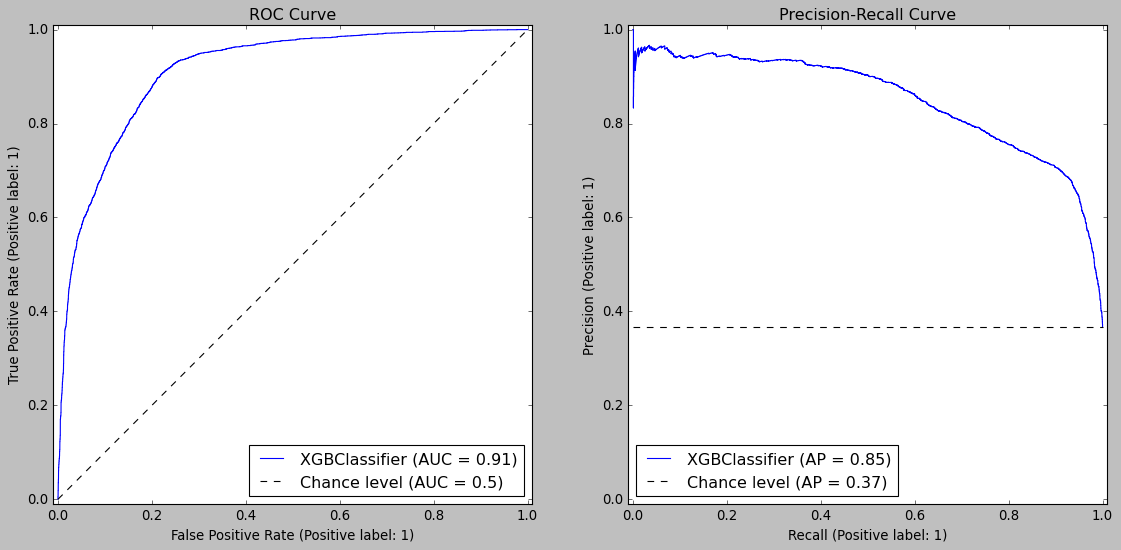

In [33]:
# Plotting the best model result
xgb_baseline_ap = XGBClassifier(**best_params_avg_precision).fit(X_train_v2,y_train)

fig, (ax1,ax2) = plt.subplots(1,2)
roc_curve = RocCurveDisplay.from_estimator(xgb_baseline_ap, X_test_v2, y_test, response_method='predict_proba', plot_chance_level=True, ax=ax1)
pr_curve = PrecisionRecallDisplay.from_estimator(xgb_baseline_ap, X_test_v2, y_test, response_method='predict_proba', plot_chance_level=True, ax=ax2)

roc_curve.figure_.set_size_inches(17,17)
roc_curve.ax_.set_title('ROC Curve')
pr_curve.ax_.set_title('Precision-Recall Curve')
plt.show()

In [40]:
# Results for data trained using XGBClassfier, optimizing for Average Precision
results_avg_precision.sort_values('Average Precision',ascending=False)

,XGBClassifier (data input),Recall,Precision,F1 Score,Accuracy,Average Precision
1,Baseline (No Resampling),0.785383,0.766094,0.775619,0.833109,0.851439
0,SMOTETomek Resampling,0.785138,0.753283,0.768881,0.826645,0.846750


In [35]:
results_avg_precision['Average Precision'] > results_for_recall.loc[[3,0],'Average Precision'].reset_index(drop=True)

0    True
1    True
Name: Average Precision, dtype: bool

- They both have almost similar performances but Baseline (No Resampling) model is slightly better. It also has a little better Average Precision than the previous Baseline model (which was optimized for recall)

- Therefore this model should be considered if both precision and recall are equally important.